In [89]:
import numpy as np
import os
import xarray as xray
import gsw

from matplotlib import pyplot as plt
%matplotlib inline

In [90]:
from griddedSatelliteData import griddedData
reload(griddedData)

<module 'griddedSatelliteData.griddedData' from 'griddedSatelliteData/griddedData.pyc'>

In [93]:
basedir = '/data/scratch/sjoerd/SST/L4MUR'
fname = os.path.join(basedir, '2003/001/20030101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')

ds = xray.open_dataset(fname)

In [5]:
ds

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2003-01-01T09:00:00
  * lat               (lat) float32 -89.99 -89.98 -89.97 -89.96 -89.95 ...
  * lon               (lon) float32 -179.99 -179.98 -179.97 -179.96 -179.95 ...
Data variables:
    analysed_sst      (time, lat, lon) float64 nan nan nan nan nan nan nan ...
    analysis_error    (time, lat, lon) float64 nan nan nan nan nan nan nan ...
    mask              (time, lat, lon) float64 2.0 2.0 2.0 2.0 2.0 2.0 2.0 ...
    sea_ice_fraction  (time, lat, lon) float64 nan nan nan nan nan nan nan ...

In [35]:
SST = ds.analysed_sst
err = ds.analysis_error
mask = ds.mask
ice_frac = ds.sea_ice_fraction
lat = ds.lat
lon = ds.lon

In [36]:
print lat.shape, lon.shape

(17999,) (36000,)


In [6]:
print mask

<xarray.DataArray 'mask' (time: 1, lat: 17999, lon: 36000)>
dask.array</data/s..., shape=(1, 17999, 36000), dtype=float64, chunksize=(1, 17999, 36000)>
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 -89.95 -89.94 -89.93 ...
  * lon      (lon) float32 -179.99 -179.98 -179.97 -179.96 -179.95 -179.94 ...
Attributes:
    long_name: sea/land field composite mask
    valid_min: 1
    valid_max: 31
    flag_masks: [ 1  2  4  8 16]
    flag_values: [ 1  2  5  9 13]
    flag_meanings: 1=open-sea, 2=land, 5=open-lake, 9=open-sea with ice in the grid, 13=open-lake with ice in the grid
    comment: mask can be used to further filter the data.
    source: GMT "grdlandmask", ice flag from sea_ice_fraction data


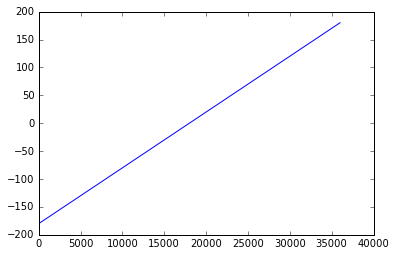

In [11]:
plt.plot(lon)

In [ ]:
plt.figure()
xray.plot.imshow(SST[0]-273)

plt.figure()
xray.plot.imshow(err[0])

plt.figure()
xray.plot.imshow(ice_frac[0])

plt.figure()
xray.plot.imshow(mask[0])

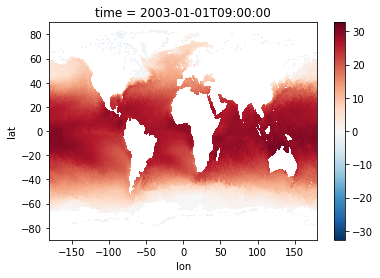

In [7]:
(SST.where(mask-1==0.)[0] - 273.15).plot(x='lon', y='lat')

In [5]:
SST_dom = ds.analysed_sst.sel(lon=slice(-50., -40.), lat=slice(25., 35.))[0] - 273.15
mask_dom = ds.mask.sel(lon=slice(-50., -40.), lat=slice(25., 35.))[0]

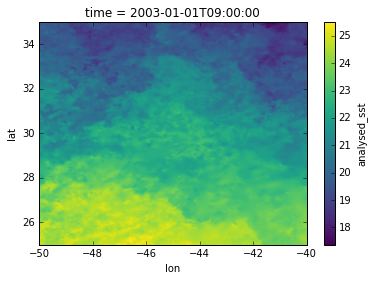

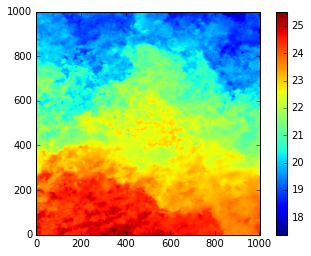

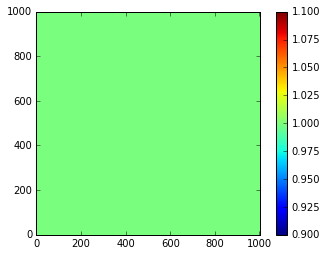

In [7]:
plt.figure()
SST_dom.plot(x='lon', y='lat')

plt.figure()
plt.imshow(SST_dom.values, origin='bottom')
plt.colorbar()

plt.figure()
plt.imshow(mask_dom.values, origin='bottom')
plt.colorbar()

In [11]:
Ny, Nx = mask_dom.shape
print mask_dom.values.sum()/(Nx*Ny)

1.0


# Try module

# Box (lat: 25~30, lon: -45~-40)

In [18]:
lonrange = (-45., -40.)
latrange = (25., 30.)
print lonrange[0]

-45.0


In [39]:
tlon = lon.sel(lon=slice(lonrange[0],
                                          lonrange[1])).values
tlat = lat.sel(lat=slice(latrange[0],
                                          latrange[1])).values
tlon[tlon<0.] += 360.

# step 1: figure out the box indices
#lon, lat = np.meshgrid(tlon, tlat)
Nx = len(tlon)
Ny = len(tlat)
dx = gsw.distance([tlon[Nx/2],tlon[Nx/2+1]], [tlat[Ny/2],tlat[Ny/2]])
dy = gsw.distance([tlon[Nx/2],tlon[Nx/2]], [tlat[Ny/2],tlat[Ny/2+1]])

In [43]:
print dx.shape, dx[0].shape

(1, 1) (1,)


In [86]:
p = griddedData.griddedFile(fname)
########
# SST
########
# %lprun -f gridded_Data.griddedFile.spectrum_2d p.spectrum_2d(roll=0, lonrange=lonrange, latrange=latrange)

In [87]:
Nx, Ny, k, l, Ti2, tilde2, breve2, Ki, isotropic_PSD, area = p.spectra(lonrange=lonrange, latrange=latrange)

In [57]:
print Ki.shape, isotropic_PSD.shape

(33,) (33,)


In [30]:
print k[len(k)/2+1], l[len(l)/2+1]

2.07913346026e-10 2.07882893454e-10


(array([  1.00000000e-07,   1.00000000e-06,   1.00000000e-05,
          1.00000000e-04,   1.00000000e-03,   1.00000000e-02,
          1.00000000e-01,   1.00000000e+00,   1.00000000e+01,
          1.00000000e+02,   1.00000000e+03,   1.00000000e+04,
          1.00000000e+05]), <a list of 13 Text yticklabel objects>)

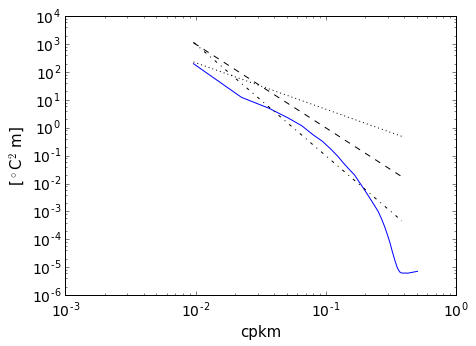

In [88]:
fig = plt.figure(figsize=(7,5))

ax = plt.gca()
ax.loglog(Ki*1e3, isotropic_PSD)
ax.loglog(Ki[1:-5]*1e3, Ki[1:-5]**-3*1e-12, 'k--')
ax.loglog(Ki[1:-5]*1e3, Ki[1:-5]**-4*1e-17, 'k-.')
ax.loglog(Ki[1:-5]*1e3, Ki[1:-5]**-(5./3.)*1e-6, 'k:')
ax.set_ylabel(r'[$^\circ$C$^2$ m]', fontsize=15)
ax.set_xlabel(r'cpkm', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Box (lat: 5~15, lon: -110~-100)

In [75]:
lonrange = (-110., -100.)
latrange = (5., 15.)
print lonrange[0]

-110.0


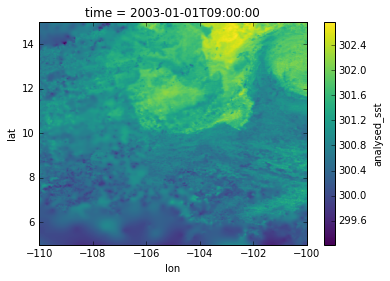

In [77]:
SST.sel(lon=slice(lonrange[0], lonrange[1]), lat=slice(latrange[0], latrange[1])).plot()

In [78]:
Nx, Ny, k, l, Ti2, tilde2, breve2, Ki, isotropic_PSD, area = p.spectra(lonrange=lonrange, latrange=latrange)

(array([  1.00000000e-07,   1.00000000e-06,   1.00000000e-05,
          1.00000000e-04,   1.00000000e-03,   1.00000000e-02,
          1.00000000e-01,   1.00000000e+00,   1.00000000e+01,
          1.00000000e+02,   1.00000000e+03,   1.00000000e+04,
          1.00000000e+05]), <a list of 13 Text yticklabel objects>)

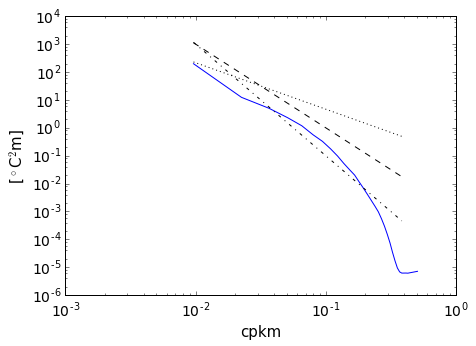

In [80]:
fig = plt.figure(figsize=(7,5))

ax = plt.gca()
ax.loglog(Ki*1e3, isotropic_PSD)
ax.loglog(Ki[1:-5]*1e3, Ki[1:-5]**-3*1e-12, 'k--')
ax.loglog(Ki[1:-5]*1e3, Ki[1:-5]**-4*1e-17, 'k-.')
ax.loglog(Ki[1:-5]*1e3, Ki[1:-5]**-(5./3.)*1e-6, 'k:')
ax.set_ylabel(r'[$^\circ$C$^2$m]', fontsize=15)
ax.set_xlabel(r'cpkm', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)